In [1]:
# Import necessary modules
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# INITIALIZATION 

# Input time T, and number of timesteps N, output initial vectors
def initialize(T, N):
    # Position
    r_range = np.zeros((N, 3))
    # Velocity
    v_range = np.zeros((N, 3))
    # Euler Angles
    angle_range = np.zeros((N, 3))
    # Angular Velocity
    omega_range = np.zeros((N, 3))
    # Time
    t_range = np.linspace(0, T, N+1)[:-1]
    # State Vector
    x = np.concatenate([r_range[0], v_range[0], angle_range[0], omega_range[0]])
    return r_range, v_range, angle_range, omega_range, t_range, x

In [3]:
# TRANSLATIONAL DYNAMICS

# Input Euler angles (phi, theta, psi) and output rotation matrix
def calc_rotation_matrix(angles):
    phi, theta, psi = angles
    R = np.array([[np.cos(phi)*np.cos(theta),
                   np.cos(phi)*np.sin(theta)*np.sin(phi) - np.sin(psi)*np.cos(phi),
                   np.cos(psi)*np.sin(theta)*np.cos(phi) + np.sin(psi)*np.sin(phi)],     
                  [np.sin(psi)*np.cos(theta),
                   np.sin(psi)*np.sin(theta)*np.sin(phi) + np.cos(psi)*np.cos(phi),
                   np.sin(psi)*np.sin(theta)*np.cos(phi)-np.cos(psi)*np.sin(phi)],
                  [-np.sin(theta),
                   np.cos(theta)*np.sin(phi),
                   np.cos(theta)*np.cos(phi)]])
    return R

# Input speeds of the rotors (omega 1, 2, 3, 4) and output thrust
def calc_thrust(k, rotor_speeds):
    omega1, omega2, omega3, omega4 = rotor_speeds
    T = k * (omega1**2 + omega2**2 + omega3**2 + omega4**2)
    T_vect = np.array([0, 0, T])
    return T_vect

# Input constants, m, g, and T and R to output linear acceleration 
def calc_linear_acceleration(m, g, angles, dir, k, rotor_speeds):
    R = calc_rotation_matrix(angles)
    T = calc_thrust(k, rotor_speeds)
    R_dir = np.array([[dir[0], -dir[1], 0],
                            [dir[1], dir[0], 0],
                            [0, 0, 1]])
    G = np.array([0, 0, m*g])
    linear_acceleration = (1/m)* (G + R_dir @ R.T @ T)
    if np.abs(linear_acceleration[2]) < 1e-6:
        linear_acceleration[2] = 0
    # print(linear_acceleration[0], linear_acceleration[1],linear_acceleration[2])
    return linear_acceleration


In [4]:
# ROTATIONAL DYNAMICS

# Input constants l, k, b, rotor speeds (omega 1,2,3,4), output the torque vector
def calc_torque(l, k, b, rotor_speeds):
    omega1, omega2, omega3, omega4 = rotor_speeds
    tau_phi = l*k*(omega4**2 - omega2**2)
    tau_theta = l*k*(omega3**2 - omega1**2)
    tau_psi = b*(omega1**2 - omega2**2 + omega3**2 - omega4**2)
    tau = np.array([tau_phi, tau_theta, tau_psi])
    return tau

# Input I values, omega (p, q, r), constants, and rotor speeds, Output the rotational acceleration wrt body frame
def calc_rotational_acceleration(I_values, omega, l, k, b, rotor_speeds):
    tau = calc_torque(l, k, b, rotor_speeds)
    # nu = calc_body_frame_angular_velocity(angles, omega)
    Ixx, Iyy, Izz = I_values
    I = np.diag([Ixx, Iyy, Izz])
    nu_dot = I @ (tau - np.cross(omega,(I @ omega)))
    return nu_dot

 


In [5]:
# PROPOGATION OVER TIME

def f(x, args):
    m, g, k, dir, rotor_speeds, I_values, l, b = args
    # Splitting up the state vector
    r = x[0:3]
    v = x[3:6]
    angle = x[6:9]
    omega = x[9:12]
    # Calculate acceleration
    a = calc_linear_acceleration( m, g, angle, dir, k, rotor_speeds)
    # Calculate angular acceleration
    alpha = calc_rotational_acceleration(I_values, omega, l, k, b, rotor_speeds)
    # print(f"xdot: {np.concatenate([v, a, omega, alpha])}")  # Debug output
    xdot = np.concatenate([v, a, omega, alpha])
    return xdot

def RK4(x, dt, args):
    k1 = f(x, args)
    k2 = f(x + dt * k1 / 2, args)
    k3 = f(x + dt * k2 / 2, args)
    k4 = f(x + dt * k3, args)
    x_posteriori = x + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    return x_posteriori


In [6]:
# PLOTS

# Plot results
def plot_results(r_range, v_range, angle_range, omega_range, t_range):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    # Plot Position (r_range)
    ax[0, 0].plot(t_range, r_range[:, 0], label=r"x", color='b')
    ax[0, 0].plot(t_range, r_range[:, 1], label=r"y", color='g')
    ax[0, 0].plot(t_range, r_range[:, 2], label=r"z", color='r')
    ax[0, 0].set_xlabel("Time (s)")
    ax[0, 0].set_ylabel("Position (m)")
    ax[0, 0].set_title("Position vs Time")
    ax[0, 0].legend()

    # Plot Velocity (v_range)
    ax[0, 1].plot(t_range, v_range[:, 0], label=r"$V_x$", color='b')
    ax[0, 1].plot(t_range, v_range[:, 1], label=r"$V_y$", color='g')
    ax[0, 1].plot(t_range, v_range[:, 2], label=r"$V_z$", color='r')
    ax[0, 1].set_xlabel("Time (s)")
    ax[0, 1].set_ylabel("Velocity (m/s)")
    ax[0, 1].set_title("Velocity vs Time")
    ax[0, 1].legend()

    # Plot Euler Angles (angle_range)
    ax[1, 0].plot(t_range, angle_range[:, 0], label=r"$\phi$", color='b')
    ax[1, 0].plot(t_range, angle_range[:, 1], label=r"$\theta$", color='g')
    ax[1, 0].plot(t_range, angle_range[:, 2], label=r"$\psi$", color='r')
    ax[1, 0].set_xlabel("Time (s)")
    ax[1, 0].set_ylabel("Angle (rad)")
    ax[1, 0].set_title("Euler Angles vs Time")
    ax[1, 0].legend()

    # Plot Angular Velocity (omega_range)
    ax[1, 1].plot(t_range, omega_range[:, 0], label=r"$p$", color='b')
    ax[1, 1].plot(t_range, omega_range[:, 1], label=r"$q$", color='g')
    ax[1, 1].plot(t_range, omega_range[:, 2], label=r"$r$", color='r')
    ax[1, 1].set_xlabel("Time (s)")
    ax[1, 1].set_ylabel("Angular Velocity (rad/s)")
    ax[1, 1].set_title("Angular Velocity vs Time")
    ax[1, 1].legend()
    plt.show()

# Plot 2D position
def plot_position_2D(r_range):
    plt.plot(r_range[:, 0], r_range[:, 1], label="Trajectory")
    plt.scatter(r_range[0, 0], r_range[0, 1], color='r', s=50, label='Starting Point')
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.text(r_range[0, 0] + 0.1, r_range[0, 1] + 0.1, 'Start', color='r')
    plt.legend()
    plt.axis('equal')
    plt.title('2D Drone Position')
    plt.show()

# Plot 3D position
def plot_position_3D(r_range):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(r_range[:,0], r_range[:,1], r_range[:,2], linewidth=2, color='b', label='Trajectory')
    point = r_range[0]  # Extracting the first point
    ax.scatter(point[0], point[1], point[2], color='r', s=10, label='Start Point')
    ax.set_zlim(0, 2)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.set_zlabel("z (m)")
    ax.set_title("3D Drone Position")
    plt.legend()
    plt.show()

In [7]:
# CONSTANTS

m = 0.225 # mass in kg
g = -9.8 # acceleration due to gravity m/s**2
k = 1.5e-5 # thrust coefficient
b = 1.32e-7 # torque coeffiecient
l = 0.15 # rotor arm length in m

# Moment of inertia
Ixx = 0.001 # rotational inertia about the x axis 
Iyy = 0.001 # rotational inertia about the y axis 
Izz = 0.002 # rotational inertia about the z axis 

I_values = np.array([Ixx, Iyy, Izz]) # rotational inertia matrix

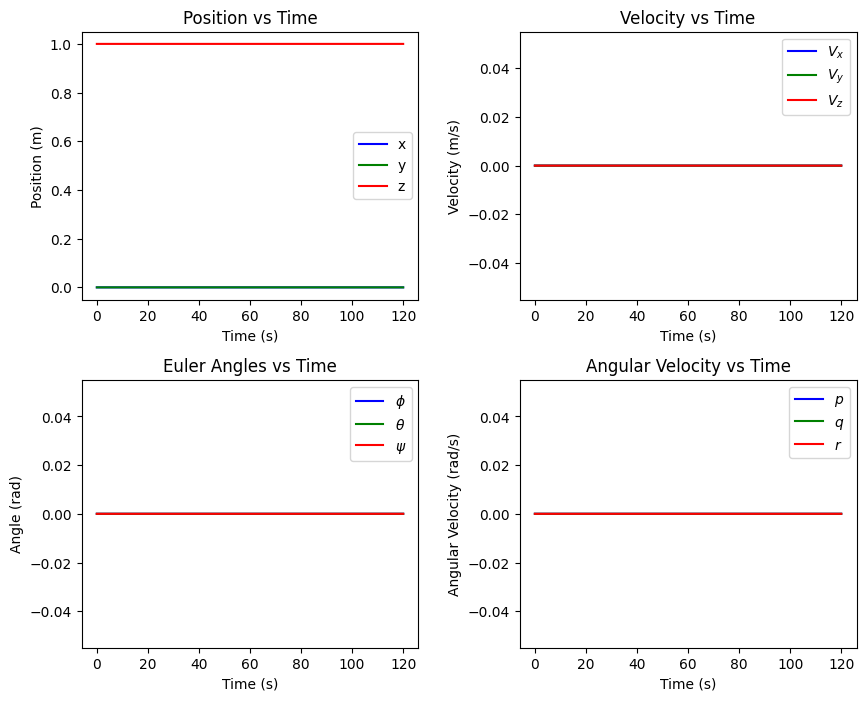

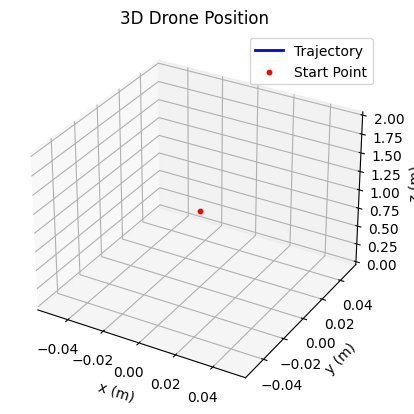

In [8]:
# HOVER

# Time
dt = 0.001 # time step in s
T = 120 # duration of simulation in s
N = int(T / dt) # number of steps

# Initialize
r_range, v_range, angle_range, omega_range, t_range, x = initialize(T, N)

# Conditions for hovering 1m above the ground
# Hovering position
r_range[0] = np.array([0, 0, 1])
x = np.concatenate([r_range[0], v_range[0], angle_range[0], omega_range[0]])
thrust = -m*g
mag_speed = np.sqrt((thrust/(4*k)))
# Rotor speeds
rotor_speed = np.array([mag_speed, -mag_speed, mag_speed, -mag_speed])
# rotor_speed = np.array([0, 0, 0, 0])
# Direction of velocity - along z axis
dir = np.array([0, 0, 1])

for t in range(1, N):
    # Defining arguments
    args = [m, g, k, dir, rotor_speed, I_values, l, b]
    
    # x at next time step
    x_posteriori = RK4(x, dt, args)

    # Recording data
    r_range[t] = x_posteriori[0:3]
    # r_range[t] = np.array([0, 0, 1])
    v_range[t] = x_posteriori[3:6]
    angle_range[t] = x_posteriori[6:9]
    omega_range[t] = x_posteriori[9:12]
    # print(f"Velocity at t={t}: {v_range[t]}")
    # print(f"Position at t={t}: {r_range[t]}")

    # Updating direction of velocity
    # direction = v_range[t] / np.linalg.norm(v_range[t])
    velocity = v_range[t]
    norm = np.linalg.norm(velocity)
    if norm > 1e-6:  # Avoid division by very small values
        dir = velocity / norm
    else:
        dir = np.array([0, 0, 1])  # Default direction (or another reasonable value)

    # Updating state vector with posteriori value
    x = x_posteriori


# Plot results
plot_results(r_range, v_range, angle_range, omega_range, t_range)
plot_position_3D(r_range)

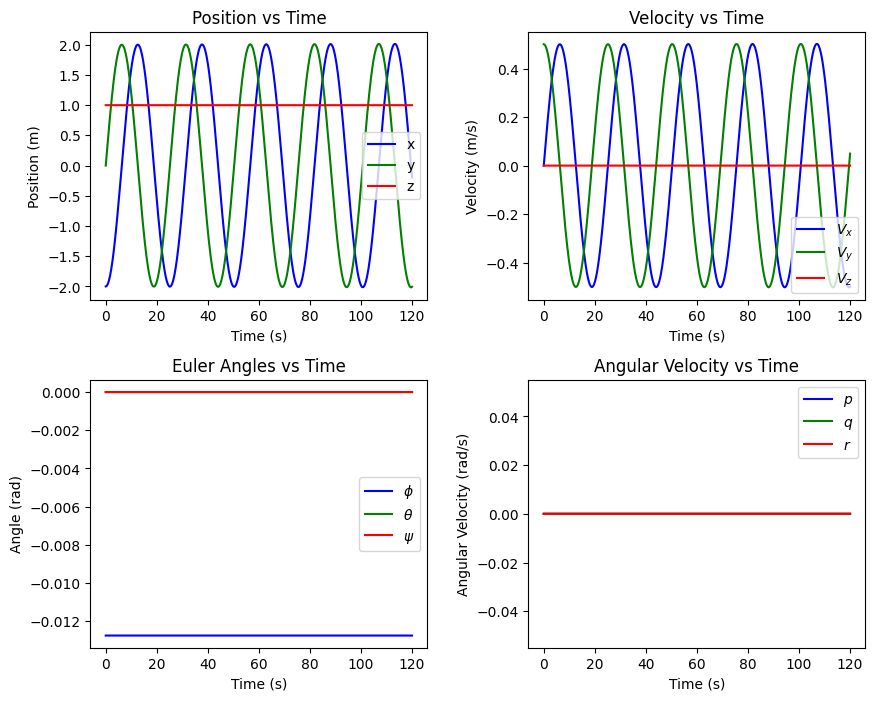

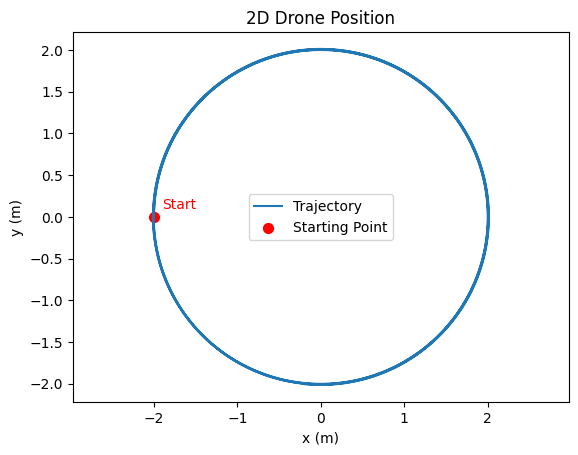

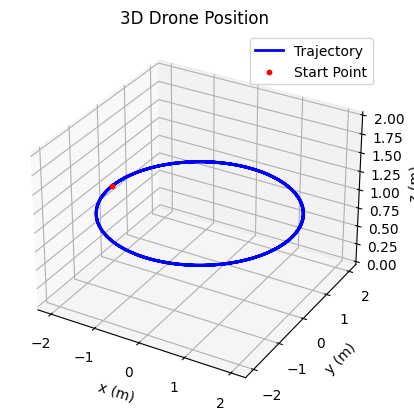

In [9]:
# CIRCLE

# Time
dt = 0.001 # time step in s
T = 120 # duration of simulation in s
N = int(T / dt) # number of steps

# Initialize
r_range, v_range, angle_range, omega_range, t_range, x = initialize(T, N)

# Conditions for circle
circle_radius = 2 # m
altitude = 1 # m
quadrotor_speed = 0.5 # m/s

# Iniital position and velocity
r_range[0] = np.array([-circle_radius, 0, altitude])
v_range[0] = np.array([0, quadrotor_speed, 0]) # tangential velocity

# Accelerations
a_c = -(quadrotor_speed ** 2) / circle_radius # Centripetal acceleration due to circular motion
a_g = -g # acceleration to counter act gravity
phi = np.arctan2(a_c,a_g) # Euler angle
angle_range[0] = np.array([phi, 0, 0])

# Calculating Rotor speeds using thrust
thrust = m * np.sqrt(a_c ** 2 + a_g ** 2)
mag_speed = np.sqrt((thrust/(4*k)))
# Rotor speeds
rotor_speed = np.array([mag_speed, -mag_speed, mag_speed, -mag_speed])

# Direction of velocity
dir = v_range[0]/np.linalg.norm(v_range[0])

x = np.concatenate([r_range[0], v_range[0], angle_range[0], omega_range[0]])

for t in range(1, N):
    # Defining arguments
    args = [m, g, k, dir, rotor_speed, I_values, l, b]
    
    # x at next time step
    x_posteriori = RK4(x, dt, args)

    # Recording data
    r_range[t] = x_posteriori[0:3]
    v_range[t] = x_posteriori[3:6]
    angle_range[t] = x_posteriori[6:9]
    omega_range[t] = x_posteriori[9:12]
    # print(f"Velocity at t={t}: {v_range[t]}")
    # print(f"Position at t={t}: {r_range[t]}")

    # Updating direction of velocity
    # direction = v_range[t] / np.linalg.norm(v_range[t])
    velocity = v_range[t]
    norm = np.linalg.norm(velocity)
    if norm > 1e-10:  # Avoid division by very small values
        dir = velocity / norm
    else:
        dir = np.array([0, quadrotor_speed, 0])  # Default direction (or another reasonable value)

    # Updating state vector with posteriori value
    x = x_posteriori


# Plot results
plot_results(r_range, v_range, angle_range, omega_range, t_range)
plot_position_2D(r_range)
plot_position_3D(r_range)